In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_r import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [2]:
os.getcwd()

'/home/dsgpucp/Documents/DSG-2018-Finals'

In [3]:
from src.utils_f import duration_feature
import lightgbm as lgbm


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')

In [6]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(all_session, all_tracking, test_size=0.4)

In [7]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [8]:
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
proc_train.head()

,sid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION
0,inxo2lfHOeGgN2ySgzK1hAKyCIt17p+honetBOQH4ICtTR...,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.041667,0.083333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000,24.0,0.000000,0.166667,0.0,0.041667,0.125,0.0,0.666667,0.000000,24.0,7840.041643
1,4CGnnv6GOcYQp/kxVjcx8nN0u5HgaDaLQkC4xIteZJZ/wK...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875000,0.000000,8.0,0.000000,0.000000,0.0,0.000000,0.125,0.0,0.875000,0.000000,8.0,288.199209
2,mh22mbOuRnDwAf2OWcrwwymfbZQ/CO3GQuNMO5NREgRV0t...,0.0,0.0,0.000000,0.0,0.0,0.833333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,6.0,0.000000,0.833333,0.0,0.000000,0.000,0.0,0.166667,0.000000,6.0,613.506545
3,K/+O1PWZ2vASLTrjvBFT7e62Vee1YyOxCrpMJNoL6edmuC...,0.0,0.0,0.181818,0.0,0.0,0.363636,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.090909,11.0,0.181818,0.363636,0.0,0.090909,0.000,0.0,0.272727,0.090909,11.0,217.223808
4,+8SAgYuptilut4CKRE59ncZFDaF4Y+PX6yJ8g4HaALCxI7...,0.0,0.0,0.000000,0.0,0.0,0.200000,0.6,0.000000,0.000000,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.0,0.000000,0.200000,0.6,0.000000,0.200,0.0,0.000000,0.000000,5.0,168.220206


# Validation

In [10]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_train)

X_train_pca = (pca.transform(X_train))
X_val_pca = (pca.transform(X_val))

X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_pca)], axis=1)
X_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(X_val_pca)], axis=1)

In [13]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284387
[200]	valid_0's binary_logloss: 0.278182
[300]	valid_0's binary_logloss: 0.27574
[400]	valid_0's binary_logloss: 0.274611
[500]	valid_0's binary_logloss: 0.274123
[600]	valid_0's binary_logloss: 0.273889
[700]	valid_0's binary_logloss: 0.273738
Early stopping, best iteration is:
[742]	valid_0's binary_logloss: 0.273701


In [14]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=774, verbose_eval=100)

[100]	valid_0's binary_logloss: 0.284387
[200]	valid_0's binary_logloss: 0.278182
[300]	valid_0's binary_logloss: 0.27574
[400]	valid_0's binary_logloss: 0.274611
[500]	valid_0's binary_logloss: 0.274123
[600]	valid_0's binary_logloss: 0.273889
[700]	valid_0's binary_logloss: 0.273738


# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=774, verbose_eval=)

In [31]:
X_all = proc_all.drop('sid', axis=1).reset_index(drop=True)
y_all = all_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)
temp_columns = X_all.columns
X_test = X_test[temp_columns]

In [32]:
scaler = StandardScaler()
scaler.fit(X_all)
X_all = scaler.transform(X_all)
X_test = scaler.transform(X_test)

In [33]:
pca = PCA(n_components = 10).fit(X_all)

X_all_pca = pd.DataFrame(pca.transform(X_all))
X_test_pca = pd.DataFrame(pca.transform(X_test))

X_all = pd.concat([pd.DataFrame(X_all), pd.DataFrame(X_all_pca)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_pca)], axis=1)

In [43]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=774)

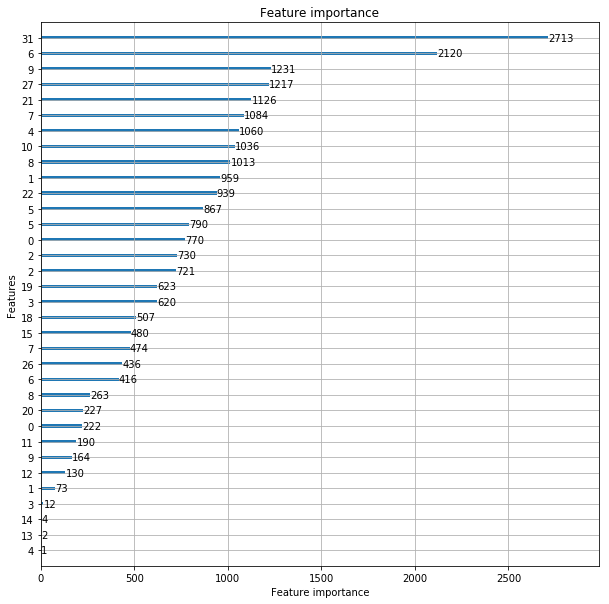

In [41]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [44]:
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_3_submit.csv', index=False)